## Algoritmo Ensamble Clasificación de Cobertura

- En el presente notebook se encuentran el proceso de clasificación de cobertura a partir de dos algoritmos diferentes Bagging y Voting de la librería Sklearn

- Algoritmo desarrollado por Ing. Yilsey Benavides Miranda para consulta directa al Cubo de Datos de Imágenes de Satelite de Colombia  - IDEAM , empleando las unidades de almacenamiento de Landsat 7 y 8,DEM, ALOS PALSAR ingestadas en el CDCol-IDEAM.

In [4]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [5]:
execID=6
algorithm = "ensemble_test"
version= "1.0"

##  Librerias 

In [6]:
import datacube
from datacube.storage import netcdf_writer
from datacube.model import Variable, CRS
import os
import re
import xarray as xr
import numpy as np
import gdal
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
import  sklearn 
from sklearn import tree
from sklearn import svm 
from sklearn.svm import SVC
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
import sklearn.metrics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.multiclass import unique_labels

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

### Definición de funciones

In [9]:
def enmascarar_entrenamiento(vector_data_path, cols, rows, geo_transform, projection, target_value=1):
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds

In [10]:
def rasterizar_entrenamiento(file_paths, rows, cols, geo_transform, projection):
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = enmascarar_entrenamiento(path, cols, rows, geo_transform, projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        #ds = None
    return labeled_pixels

In [11]:
def exportar(fname, data, geo_transform, projection):
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2. 
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Definición de Consulta

#### Parámetros de Consulta

##### Los parametros que encontrará a continuación corresponde 

- products = Unidad de almacenamiento que desea consultar (Sátelite), Landsat 5, 7 y 8 
- bands = Las bandas que desea emplear para el calculo de medianas y los índices que encontrará debajo  de la función de medianas
- time_ranges = Rango o periodo de tiempo a cosultar (Veriricar que corresponda a los datos disponibles por unidad de almacenamiento)
- Área = El usuario debe definir la longitud mínima, máxima y la latitud mínima, máxima del área de consulta
- normalized = Función para normalizar los valores resultantes del cálculo de las medianas
- minValid = Valor mínimo valido que empleará el algoritmo  para el cálculo de las medianas
- nodata= -9999 Es el valor por defecto que se dará a los valores no data en el cálculo de las medianas

In [13]:
products = ['LS8_OLI_LASRC','LS7_ETM_LEDAPS' ] #Productos sobre los que se hará la consulta (unidades de almacenamiento)
#products = ['LS8_OLI_LASRC' ] #Productos sobre los que se hará la consulta (unidades de almacenamiento)
bands=["blue","green","red","nir", "swir1","swir2"] #arreglo de bandas #"blue","green",
time_ranges = [("2017-01-01", "2017-12-30")] #Una lista de tuplas, cada tupla representa un periodo
#área sobre la cual se hará la consulta:
min_long = -73
min_lat = 4.1
max_long = -72.7
max_lat = 4.5
nodata=-9999

### Selección de carpetas donde se encuentran los shapefile

- train_data_path= Se refiere a la carpeta que contiene los shapefile de entrenamiento del para la clasificación

- validation_data_path= Se refiere a la carpeta que contiene los shapefile de validación del para la clasificación

In [14]:
train_data_path = '/home/cubo/jupyter/500/TEST/'
validation_data_path= '/home/cubo/jupyter/500/TRAIN'
normalized=False
minValid=1

### Máscara de nubes

Con el nuevo formato, los valores de `pixel_qa` dependen del producto. Para crear la máscara de nubes, se determinan los valores válidos para el producto actual y se usa la banda `pixel_qa` para generar un arreglo de datos booleanos: Para cada posición, si el valor de pixel_qa está en la lista de valores válidos será `True`, en caso contrario será `False`.

In [15]:
kwargs={}
dc = datacube.Datacube(app="{}_{}_{}".format(algorithm,version,execID))
for product in products:
    i=0
    validValues=set()
    if product=="LS7_ETM_LEDAPS":
        validValues=[66,68,130,132]
    elif product == "LS8_OLI_LASRC":
        validValues=[322, 386, 834, 898, 1346, 324, 388, 836, 900, 1348]
    for tr in time_ranges:
        _data = dc.load(product=product, longitude=(min_long, max_long), latitude=(min_lat, max_lat), time=tr)
        if len(_data.data_vars)==0:
            break
        cloud_mask=np.isin(_data["pixel_qa"].values, validValues)
        for band in bands:
            _data[band].values=np.where(np.logical_and(_data.data_vars[band]!=nodata,cloud_mask),_data.data_vars[band], np.nan)
        _undesired=list(set(_data.keys())-set(bands+['latitude','longitude','time']))
        _data=_data.drop(_undesired)
            
        if "xarr"+str(i) in kwargs:
            kwargs["xarr"+str(i)]=xr.concat([kwargs["xarr"+str(i)],_data.copy(deep=True)], 'time')
        else:
            kwargs["xarr"+str(i)]=_data
    i+=1
del _data

In [16]:
_undesired

['radsat_qa',
 'sensor_azimuth',
 'pixel_qa',
 'cloud_qa',
 'solar_zenith',
 'atmos_opacity',
 'solar_azimuth',
 'sensor_zenith']

In [17]:
#El algoritmo recibe los productos como xarrays en variablles llamadas xarr0, xarr1, xarr2... 
xarr0=kwargs["xarr0"]
#del kwargs

In [18]:
#Lista de bandas consultadas en el arreglo
list(xarr0.data_vars)

['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

#### Función de Consulta de unidad de almacenamiento DEM con parámetros asignados

In [19]:
_data2 = dc.load(product="DEM_Mosaico", longitude=(min_long, max_long), latitude=(min_lat, max_lat), time=("2013-01-01", "2013-12-31"))
dem=_data2["dem"][0].values
del _data2

#### Función de Consulta de unidad de almacenamiento Bosque No Bosque con parámetros asignados

In [20]:
dc = datacube.Datacube(app="{}_{}_{}".format(algorithm,version,execID))

_data3 = dc.load(product="FNF_COL_UTM", longitude=(min_long, max_long), latitude=(min_lat, max_lat), time=("2016-01-01", "2016-12-31"))

In [21]:
_data3

<xarray.Dataset>
Dimensions:    (latitude: 1475, longitude: 1112, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01
  * latitude   (latitude) float64 4.5 4.5 4.499 4.499 4.499 4.499 4.498 ...
  * longitude  (longitude) float64 -73.0 -73.0 -73.0 -73.0 -73.0 -73.0 -73.0 ...
Data variables:
    fnf_mask   (time, latitude, longitude) int8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 ...
Attributes:
    crs:      EPSG:4686

#### Función cálculo de medianas de la consulta anterior 

In [22]:
medians={} 
for band in bands:
    datos=xarr0[band].values
    allNan=~np.isnan(datos) #Una mascara que indica qué datos son o no nan. 
    if normalized: #Normalizar, si es necesario.
        #Para cada momento en el tiempo obtener el promedio y la desviación estándar de los valores de reflectancia
        m=np.nanmean(datos.reshape((datos.shape[0],-1)), axis=1)
        st=np.nanstd(datos.reshape((datos.shape[0],-1)), axis=1)
        # usar ((x-x̄)/st) para llevar la distribución a media 0 y desviación estándar 1, 
        # y luego hacer un cambio de espacio para la nueva desviación y media. 
        datos=np.true_divide((datos-m[:,np.newaxis,np.newaxis]), st[:,np.newaxis,np.newaxis])*np.nanmean(st)+np.nanmean(m)
    #Calcular la mediana en la dimensión de tiempo 
    medians[band]=np.nanmedian(datos,0) 
    #Eliminar los valores que no cumplen con el número mínimo de pixeles válidos dado. 
    medians[band][np.sum(allNan,0)<minValid]=np.nan
    medians[band][_data3["fnf_mask"].values[0]==1]=np.nan

del datos
#del _data

#### Cálculo de índices a partir de la consulta de medianas realizada anteriormente

In [23]:
medians["dem"]=dem

In [24]:
medians["ndvi"]=np.true_divide(medians["nir"]-medians["red"],medians["nir"]+medians["red"])

In [25]:
medians["nbr"]=np.true_divide(medians["nir"]-medians["swir1"],medians["nir"]+medians["swir1"])

In [26]:
medians["nbr2"]=np.true_divide(medians["swir1"]-medians["swir2"],medians["swir1"]+medians["swir2"])

In [27]:
medians["ndmi"]=np.true_divide(medians["nir"]-medians["swir1"],medians["nir"]+medians["swir1"])

In [28]:
medians["gndvi"]=np.true_divide(medians["nir"]-medians["green"],medians["nir"]+medians["green"])

In [29]:
medians["rvi"]=np.true_divide(medians["nir"],medians["red"])

In [30]:
#Near-infrared reﬂectance of vegetation
medians["nirv"]=(medians["ndvi"] * medians["nir"])

In [31]:
#Optimized Soil Adjusted Vegetation Index (OSAVI). 
medians["osavi"]=np.true_divide(medians["nir"]-medians["red"],medians["nir"]+medians["red"]+0.16)

In [32]:
medians

{'blue': array([[196. , 208. , 203. , ..., 377. , 397. , 409. ],
        [198. , 218.5, 206.5, ..., 375. , 399.5, 429. ],
        [194.5, 202.5, 207.5, ..., 394. , 417.5, 445. ],
        ...,
        [558. , 574. , 524. , ..., 412.5, 435. , 435. ],
        [579. , 555. , 516.5, ..., 391.5, 477. , 480. ],
        [580. , 553. , 526. , ..., 441. , 411.5, 479. ]]),
 'green': array([[466. , 467. , 471. , ..., 781. , 795. , 798. ],
        [460.5, 476. , 474. , ..., 760. , 792.5, 796. ],
        [451. , 463. , 464. , ..., 761. , 785.5, 788. ],
        ...,
        [930. , 939. , 922. , ..., 742. , 723. , 709. ],
        [949. , 907.5, 914. , ..., 709.5, 772. , 774. ],
        [966. , 909.5, 921. , ..., 709. , 706.5, 737. ]]),
 'red': array([[ 282. ,  315. ,  305. , ...,  675. ,  699.5,  699. ],
        [ 286.5,  307.5,  302. , ...,  660.5,  694. ,  695. ],
        [ 279.5,  307. ,  306. , ...,  655. ,  694. ,  703. ],
        ...,
        [1038. ,  988. ,  960. , ...,  859.5,  827. ,  850. 

In [33]:
nbar=xarr0

#### (Opcional)--Preparar salida de medianas e índices para exportar

In [34]:
import xarray as xr
ncoords=[]
xdims =[]
xcords={}
for x in nbar.coords:
    if(x!='time'):
        ncoords.append( ( x, nbar.coords[x]) )
        xdims.append(x)
        xcords[x]=nbar.coords[x]
variables ={k: xr.DataArray(v, dims=xdims,coords=ncoords)
             for k, v in medians.items()}
output=xr.Dataset(variables, attrs={'crs':nbar.crs})
for x in output.coords:
    output.coords[x].attrs["units"]=nbar.coords[x].units

In [35]:
output1=output.expand_dims(dim='time',axis=0)
output=output1

In [36]:
from utils.data_cube_utilities.import_export import export_xarray_to_geotiff
export_xarray_to_geotiff(output, "output/mediana_fnf_33")

In [37]:
bands=list(medians.keys())
_coords=xarr0.coords
_crs=xarr0.crs
#del xarr0

In [38]:
medians[bands[0]].shape

(1475, 1112)

In [39]:
rows, cols = medians[bands[0]].shape
#(originX, pixelWidth, 0, originY, 0, pixelHeight)
geo_transform=(_coords["longitude"].values[0], 0.000269995,0, _coords["latitude"].values[0],0,-0.000271302)
proj=_crs.wkt
#proj='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'

###  Rasterización de muestras  

#### Inicio  Random forest training segunda parte mismo algoritmo

In [40]:
#Se llamarán los shapefile definidos para el entrenamiento del algoritmo y que se designaron en la ruta de "train_data_path"
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(train_data_path, f) for f in files if f.endswith('.shp')]
shapefiles.sort()
shapefiles

['/home/cubo/jupyter/500/TEST/Cuerpos_Agua.shp',
 '/home/cubo/jupyter/500/TEST/Cultivos.shp',
 '/home/cubo/jupyter/500/TEST/Pastos.shp',
 '/home/cubo/jupyter/500/TEST/Zona_Pantanosa.shp']

In [41]:
#Asignación de coordenadas para el arreglo definido para realizar la clasificación 
#(originX, pixelWidth, 0, originY, 0, pixelHeight)
rows, cols = medians[bands[0]].shape
geo_transform=(_coords["longitude"].values[0], 0.000269995,0, _coords["latitude"].values[0],0,-0.000271302)
proj=_crs.wkt
#proj='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'

In [42]:
##Se realiza la rasterización de las muestras de shapefile en el área seleccionada
labeled_pixels = rasterizar_entrenamiento(shapefiles, rows, cols, geo_transform, proj)

In [43]:
%%time
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
bands_data=[]
for band in bands: 
    bands_data.append(medians[band])
bands_data = np.dstack(bands_data)

CPU times: user 304 ms, sys: 3.73 s, total: 4.03 s
Wall time: 4.04 s


In [44]:
training_samples = bands_data[is_train]
rows, cols, n_bands = bands_data.shape
np.isfinite(training_samples)
#Máscara eliminación de valores infinitos que puedan surgir en el proceso de rasterización y que influyen en el proceso de clasificación
_msk=np.sum(np.isfinite(training_samples),1)>1
training_samples= training_samples[_msk,:]
training_labels=training_labels[_msk]

In [45]:
#Máscara remplazo de los valores nan por valor no data
mask_nan=np.isnan(training_samples)
training_samples[mask_nan]=-9999
training_labels = np.array(training_labels,dtype='int64')
unique_labels(training_labels)
training_labels

array([1, 1, 1, ..., 2, 2, 2])

In [46]:
%%time
#En caso de que se obtengan valores de entrenamiento o "training labels" diferentes de las clases inicialmente ingresadas estos valore se deberan enviar a alguna de las clases existentes
#como se muestra a continuación "mk_training_labels" será la mascara que envie los valores diferentes a la clase que eligamos y se debera indicar en reemplazando el valor para el ejemplo corresponde al número "4"
#mk_training_labels = (training_labels > 4)
#training_labels[mk_training_labels]= 4
unique_labels(training_labels)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 274 µs


array([1, 2, 3, 4])

### Primera clasificación con algoritmo de Ensamble Bagging


In [47]:
##Definición de parámetros para cada uno de los algoritmos de máquinas de aprendizaje que se emplearan en el algoritmo de ensamble Bagging 
##Algoritmo Random Forest 
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, verbose=1)
##Algoritmo Decision Tree
dtree=tree.DecisionTreeClassifier(criterion='gini')
##Algoritmo Support Vector Machine in branch Linear
svml=SVC(C=1.0,  class_weight='balanced',decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
           max_iter=-1, probability=False, random_state=None, shrinking=True,tol=0.001, verbose=False)
##Algoritmo Knearest Neighbors
#knn = KNeighborsClassifier(algorithm='brute',n_neighbors=3,metric='mahalanobis')
##Algoritmo Neural Netkwork
nn = MLPClassifier(alpha=0.0001,  hidden_layer_sizes=(500,),random_state=None,max_iter=500,activation = 'logistic',solver='adam')
##Algoritmo Gradient Boosting 
grad_boost=GradientBoostingClassifier(n_estimators=500,learning_rate=1)
##Algoritmo Extra Tree
extrat = ExtraTreesClassifier(n_estimators=50, max_depth=None,class_weight='balanced')
##Lista que contienen los algoritmos de máquinas de aprendizaje sobre los cuales se va a iterar
clf_array=[rf,dtree,svml,nn,grad_boost,extrat]#nn,

In [48]:
labeled_pixels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
##Cálculo de mediana y desviación estandar correspondiente a la clasificación de cada algoritmo de máquina de aprendizaje comparado con los mismos valores estadísticos empleando el algoritmo de ensamble Bagging que optimiza los valores resultantes de estos algoritmos de máquinas de aprendizaje.
for clf in clf_array:
    vanilla_scores = cross_val_score(clf, training_samples, training_labels, cv=2, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf)
    bagging_scores = cross_val_score(bagging_clf,training_samples, training_labels, cv=2, 
       n_jobs=-1)
    
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f}[{0}]"  
                       .format(clf.__class__.__name__, 
                       vanilla_scores.mean(), vanilla_scores.std()))
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n"
                       .format(clf.__class__.__name__, 
                        bagging_scores.mean(), bagging_scores.std()))

Mean of: 0.684, std: (+/-) 0.024[RandomForestClassifier]
Mean of: 0.674, std: (+/-) 0.017 [Bagging RandomForestClassifier]

Mean of: 0.573, std: (+/-) 0.014[DecisionTreeClassifier]
Mean of: 0.631, std: (+/-) 0.013 [Bagging DecisionTreeClassifier]

Mean of: 0.625, std: (+/-) 0.040[SVC]
Mean of: 0.629, std: (+/-) 0.036 [Bagging SVC]

Mean of: 0.680, std: (+/-) 0.004[MLPClassifier]
Mean of: 0.700, std: (+/-) 0.006 [Bagging MLPClassifier]

Mean of: 0.628, std: (+/-) 0.005[GradientBoostingClassifier]
Mean of: 0.635, std: (+/-) 0.021 [Bagging GradientBoostingClassifier]

Mean of: 0.677, std: (+/-) 0.006[ExtraTreesClassifier]
Mean of: 0.680, std: (+/-) 0.001 [Bagging ExtraTreesClassifier]



In [50]:
##Clasificación de la imagen  empleando el algoritmo de ensamble Bagging a partir de los datos de entrenamiento rasterizados
bagging_clf.fit(training_samples, training_labels)
bagging_clf.score(training_samples, training_labels)

0.999198717948718

In [51]:
#Estádistica de algoritmo de ensamble Bagging
print(bagging_scores.mean())
print(bagging_scores.std())

0.6802884615384616
0.0008012820512820484


#### Exportar el Modelo de entrenamiento Bagging

In [52]:
from sklearn.externals import joblib
joblib.dump(bagging_clf,'modelo_bagg_43')

/home/cubo/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['modelo_bagg_43']

In [53]:
bagging_clf

BaggingClassifier(base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                      class_weight='balanced',
                                                      criterion='gini',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=50,
                                                      n_jobs=None,
                           

In [54]:
#Preparación de arreglo de salida clasificada
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
flat_pixels
#Máscara remplazo de los valores nan por valor no data
mask_nan=np.isnan(flat_pixels)
flat_pixels[mask_nan]=-9999
result = bagging_clf.predict(flat_pixels)
#Guardar resultado en el arreglo "classification1"
classification1 = result.reshape((rows, cols))

#### Máscara de Bosque no Bosque consultada en el cubo se reemplazan los valores correspondientes al bosque por valores nan

In [55]:
fnf_mas=np.isin(_data3["fnf_mask"].values[0]==1, np.nan)

In [56]:
classification=np.where(_data3["fnf_mask"].values[0]==1,np.nan,classification1)

#### Preparar salida  de clasificación en formato tiff

In [62]:
##Los archivos de salida se almacenarán en la carpeta que se crea a continuación con el nombre "output", debe cambiarse el nombre de la salida despues del "/" de la carpeta "output/" a su preferencia como se presenta en la linea de ejemplo, la salida quedará en formato tiff "/output/salida_bagg.tiff"
!mkdir -p output
exportar("output/salida_bagg_med_fnf_00304.tiff", classification, geo_transform, proj)

### Primera validación con algoritmo de Ensamble Bagging

In [63]:
#Se llamarán los shapefile definidos para el entrenamiento del algoritmo y que se designaron en la ruta de "validation_data_path"
files = [f for f in os.listdir(validation_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles2 = [os.path.join(validation_data_path, f) for f in files if f.endswith('.shp')]
shapefiles2.sort()
shapefiles2

['/home/cubo/jupyter/500/TRAIN/Cuerpos Agua.shp',
 '/home/cubo/jupyter/500/TRAIN/Cultivos.shp',
 '/home/cubo/jupyter/500/TRAIN/Pastos.shp',
 '/home/cubo/jupyter/500/TRAIN/Zona_Pantanosa.shp']

In [64]:
%%time
verification_pixels = rasterizar_entrenamiento(shapefiles2, rows, cols, geo_transform, proj)
for_verification = np.nonzero(verification_pixels)
verification_labels = verification_pixels[for_verification]
predicted_labels = classification[for_verification]

CPU times: user 44 ms, sys: 8 ms, total: 52 ms
Wall time: 49 ms


In [65]:
verification_labels = np.array(verification_labels,dtype='int64')
predicted_labels = np.array(predicted_labels,dtype='int64')

In [66]:
unique_labels(predicted_labels)

array([-9223372036854775808,                    1,                    2,
                          3,                    4])

In [68]:
#En caso de que se obtengan valores de entrenamiento o "predicted_labels" diferentes de las clases inicialmente ingresadas estos valore se deberan enviar a alguna de las clases existentes
#como se muestra a continuación "mk_training_labels" será la mascara que envie los valores diferentes a la clase que eligamos y se debera indicar en reemplazando el valor para el ejemplo corresponde al número "1" y en la sección "verification_labels[predicted_labels]= 11" en el valor númerico "11" se asigna a la clase que se desee. 
mk_predicted_labels = (predicted_labels < 1)
predicted_labels[mk_predicted_labels]= 1

In [69]:
#En caso de que se obtengan valores de entrenamiento o "predicted_labels" diferentes de las clases inicialmente ingresadas estos valore se deberan enviar a alguna de las clases existentes
#como se muestra a continuación "mk_training_labels" será la mascara que envie los valores diferentes a la clase que eligamos y se debera indicar en reemplazando el valor para el ejemplo corresponde al número "1" y en la sección "verification_labels[predicted_labels]= 11" en el valor númerico "11" se asigna a la clase que se desee. 
mk_verification_labels = (verification_labels > 4)
verification_labels[mk_verification_labels]= 4

In [70]:
unique_labels(verification_labels)

array([1, 2, 3, 4])

In [71]:
unique_labels(predicted_labels)

array([1, 2, 3, 4])

In [72]:
#Generación de matriz de confusión con las clases ingresadas en el shapefile 
sklearn.metrics.confusion_matrix(verification_labels,predicted_labels)

array([[436,  20,   7, 167],
       [  4, 374, 172,  54],
       [  3, 117, 502,  10],
       [ 92,  25,  48, 473]])

In [73]:
#Enumeración o asignación de clases que se emplearon en el algoritmo de clasificación
#Se deberá realizar la asignación de nombre a cada clase que se empleo cambiando la información que se encuentra entre comillas para el ejemplo "ejemplo"
classe = np.array(['','111',
 '231',                  
 '233',
 '311123'])

#### Importancia de las variables empleadas en el algoritmo 

In [120]:
#Importancia de las variables empleadas en el algoritmo Extra Trees
model = ExtraTreesClassifier()
model.fit(training_samples, training_labels)
print(model.feature_importances_)

In [123]:
list(model.feature_importances_)

[0.03608198168461498,
 0.049121814009189864,
 0.06210752047643831,
 0.037880779531140996,
 0.13835123566472327,
 0.08865222915998454,
 0.04327182604262322,
 0.057719365295794384,
 0.05448363749768175,
 0.05997256519147914,
 0.06410840387334561,
 0.08687424350069502,
 0.05349295450038913,
 0.09193417184847848,
 0.0759472717234214]

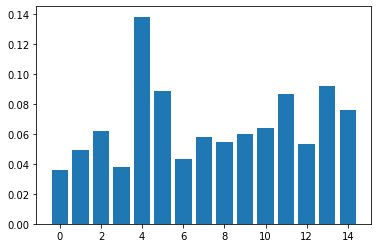

In [124]:
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [125]:
#Importancia de las variables empleadas en el algoritmo RandomForestClassifier
model = RandomForestClassifier()
model.fit(training_samples, training_labels)
print(model.feature_importances_)
print(list(model.feature_importances_))

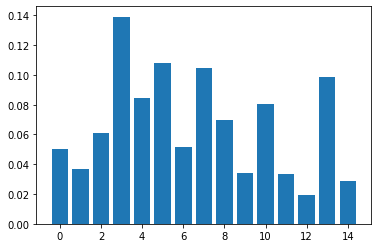

In [129]:
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [130]:
# #Importancia de las variables empleadas en el algoritmo Gradient Boosting Classifier
model = GradientBoostingClassifier()
model.fit(training_samples, training_labels).
print(model.feature_importances_)
print(list(model.feature_importances_))

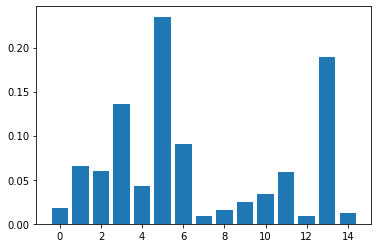

In [134]:
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [135]:
# #Importancia de las variables empleadas en el algoritmo Bagging Classifier
model = BaggingClassifier()
model.fit(training_samples, training_labels).
print(model.feature_importances_)
print(list(model.feature_importances_))

In [75]:
print("Coeficiente Precisión")
print(sklearn.metrics.accuracy_score(verification_labels, predicted_labels))
print("coeficiente Kappa")
print (cohen_kappa_score (verification_labels, predicted_labels))

Coeficiente Precisión
0.7128594249201278
coeficiente Kappa
0.6168876408654659


### Primera clasificación con algoritmo de Ensamble Voting

In [76]:
%%time
##Cálculo de mediana y desviación estandar correspondiente a la clasificación de cada algoritmo de máquina de aprendizaje comparado con los mismos valores estadísticos empleando el algoritmo de ensamble Bagging que optimiza los valores resultantes de estos algoritmos de máquinas de aprendizaje.
##Lista que contienen los algoritmos de máquinas de aprendizaje sobre los cuales se va a iterar
clf_array=[rf,dtree,nn,svml,extrat]
##Inicio de la clasificación en el ensamble de Voting empleando  los algoritmos definidos al inicio del codigo 
##Se pueden agregar más algoritmos definiendo las caracteristicas del mismo y asignando un pseudonimo y en comillas sencillas el nombre con el que se identificará
eclf = VotingClassifier(estimators=[('Random Forest', rf), ('Decision Tree' , dtree), ('SVML', svml), ('NN', nn),('GRADIENT',grad_boost),('EXTRAT',extrat)])

for clf_array, label in zip([rf,dtree,nn,extrat,eclf], ['Random Forest', 'Decision Tree','SVML', 'NN','GRADIENT','EXTRAT', 'Ensemble']):#'NN',
    scores = cross_val_score(clf_array, training_samples, training_labels, cv=2, scoring='accuracy')
    print("Accuracy: %0.3f ( %0.3f) [%s]" % (scores.mean(), scores.std(), label))
    
    
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f}[{0}]"  
                       .format(eclf.__class__.__name__, 
                       vanilla_scores.mean(), vanilla_scores.std()))
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n"
                       .format(clf.__class__.__name__, 
                        scores.mean(), scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


Accuracy: 0.688 ( 0.036) [Random Forest]
Mean of: 0.677, std: (+/-) 0.006[VotingClassifier]
Mean of: 0.688, std: (+/-) 0.036 [Bagging ExtraTreesClassifier]

Accuracy: 0.575 ( 0.002) [Decision Tree]
Mean of: 0.677, std: (+/-) 0.006[VotingClassifier]
Mean of: 0.575, std: (+/-) 0.002 [Bagging ExtraTreesClassifier]

Accuracy: 0.658 ( 0.020) [SVML]
Mean of: 0.677, std: (+/-) 0.006[VotingClassifier]
Mean of: 0.658, std: (+/-) 0.020 [Bagging ExtraTreesClassifier]

Accuracy: 0.674 ( 0.020) [NN]
Mean of: 0.677, std: (+/-) 0.006[VotingClassifier]
Mean of: 0.674, std: (+/-) 0.020 [Bagging ExtraTreesClassifier]



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


Accuracy: 0.676 ( 0.024) [GRADIENT]
Mean of: 0.677, std: (+/-) 0.006[VotingClassifier]
Mean of: 0.676, std: (+/-) 0.024 [Bagging ExtraTreesClassifier]

CPU times: user 49 s, sys: 1.3 s, total: 50.3 s
Wall time: 41 s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


In [77]:
%%time
eclf.fit(training_samples, training_labels)
eclf.score(training_samples, training_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


CPU times: user 36.1 s, sys: 0 ns, total: 36.1 s
Wall time: 34.3 s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


#### Exportar Modelo Voting

In [113]:
from sklearn.externals import joblib
##Cambiar el nombre del archivo pkl a exportar reemplazando los caracteres que se encuentran entre comillas sencillas
joblib.dump(eclf,'modelo_vot')

['modelo_vot']

In [114]:
#Preparación de arreglo de salida clasificada
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
flat_pixels
#Máscara remplazo de los valores nan por valor no data
mask_nan=np.isnan(flat_pixels)
flat_pixels[mask_nan]=-9999
result = eclf.predict(flat_pixels)
#Guardar resultado en el arreglo "classification1"
classification1 = result.reshape((rows, cols))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   51.4s finished


In [115]:
classification1

array([[2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3],
       ...,
       [2, 2, 2, ..., 2, 2, 3],
       [2, 2, 2, ..., 3, 2, 2],
       [2, 2, 2, ..., 3, 3, 3]])

#### Máscara de Bosque no Bosque consultada en el cubo se reemplazan los valores correspondientes al bosque por valores nan

In [ ]:
fnf_mas=np.isin(_data3["fnf_mask"].values[0]==1, np.nan)

In [ ]:
classification=np.where(_data3["fnf_mask"].values[0]==1,np.nan,classification1)

#### Preparar salida  de clasificación en formato tiff

In [ ]:
##Los archivos de salida se almacenarán en la carpeta que se crea a continuación con el nombre "output", debe cambiarse el nombre de la salida despues del "/" de la carpeta "output/" a su preferencia como se presenta en la linea de ejemplo, la salida quedará en formato tiff "/output/salida_bagg.tiff"
!mkdir -p output
exportar("output/salida_voting_med_fnf_00304.tiff", classification, geo_transform, proj)

#### Importancia de las variables empleadas en el algoritmo 

In [78]:
#Importancia de las variables empleadas en el algoritmo Extra Trees
model = ExtraTreesClassifier()
model.fit(training_samples, training_labels)
print(model.feature_importances_)

[0.05980105 0.0502369  0.06648792 0.04542641 0.10995232 0.07919911
 0.09755497 0.06764796 0.05637628 0.04029209 0.04357708 0.09018777
 0.05541347 0.04892446 0.08892221]


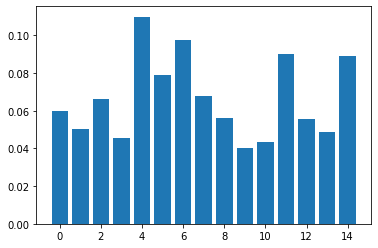

In [79]:
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [80]:
#Importancia de las variables empleadas en el algoritmo RandomForestClassifier
model = RandomForestClassifier()
model.fit(training_samples, training_labels)
print(model.feature_importances_)
print(list(model.feature_importances_))

[0.0411835  0.06714256 0.07340224 0.03312374 0.10633775 0.08197687
 0.07516796 0.05594085 0.06055664 0.06215155 0.0597694  0.09370165
 0.05477189 0.06656927 0.06820413]
[0.041183497559215416, 0.06714256452785704, 0.07340224324168346, 0.0331237378254729, 0.1063377524162385, 0.0819768718718729, 0.07516795546899672, 0.05594084932995646, 0.06055663696376206, 0.06215154904340868, 0.059769403371355355, 0.09370165292547356, 0.05477189155235398, 0.06656926844762934, 0.06820412545472376]


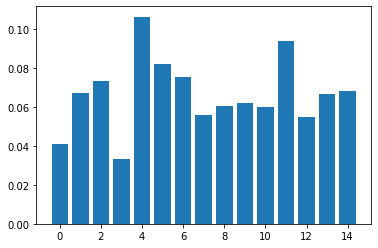

In [81]:
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [83]:
# #Importancia de las variables empleadas en el algoritmo Gradient Boosting Classifier
model = GradientBoostingClassifier()
model.fit(training_samples, training_labels)
print(model.feature_importances_)
print(list(model.feature_importances_))

[0.046832   0.07143174 0.07264577 0.02016085 0.14434485 0.12790439
 0.14253418 0.0080893  0.01601641 0.07510683 0.01562455 0.13658666
 0.0329071  0.04370286 0.04611251]
[0.04683200144980136, 0.07143173672273892, 0.07264576778867153, 0.02016085098197053, 0.1443448502252801, 0.12790439290086095, 0.14253418065114887, 0.008089298322539733, 0.016016408374717288, 0.07510683294703689, 0.01562455475559815, 0.13658666009170667, 0.032907096813641935, 0.043702858020965865, 0.046112509953321265]


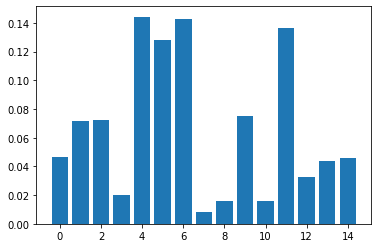

In [84]:
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [88]:
# #Importancia de las variables empleadas en el algoritmo Bagging Classifier
model = VotingClassifier()
model.fit(training_samples, training_labels)
print(model.feature_importances_)
print(list(model.feature_importances_))

TypeError: __init__() missing 1 required positional argument: 'estimators'

In [95]:
#Opcional lista de clases correspondientes a los shapefile de validación
dict(zip(classes, np.unique(classification)))

{'Cuerpos Agua': 1.0, 'Zona_Pantanosa': 2.0, 'Pastos': 3.0, 'Cultivos': 4.0}

### Primera validación con algoritmo de Ensamble Voting

In [96]:
files = [f for f in os.listdir(validation_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles2 = [os.path.join(validation_data_path, f) for f in files if f.endswith('.shp')]
shapefiles2.sort()
shapefiles2

['/home/cubo/jupyter/500/TRAIN/Cuerpos Agua.shp',
 '/home/cubo/jupyter/500/TRAIN/Cultivos.shp',
 '/home/cubo/jupyter/500/TRAIN/Pastos.shp',
 '/home/cubo/jupyter/500/TRAIN/Zona_Pantanosa.shp']

In [97]:
verification_pixels = rasterizar_entrenamiento(shapefiles2, rows, cols, geo_transform, proj)
for_verification = np.nonzero(verification_pixels)
verification_labels = verification_pixels[for_verification]
predicted_labels = classification[for_verification]

In [103]:
unique_labels(predicted_labels)

array([1, 2, 3, 4])

In [105]:
unique_labels(verification_labels)

array([1, 2, 3, 4])

In [102]:
#En caso de que se obtengan valores de entrenamiento o "predicted_labels" diferentes de las clases inicialmente ingresadas estos valore se deberan enviar a alguna de las clases existentes
#como se muestra a continuación "mk_training_labels" será la mascara que envie los valores diferentes a la clase que eligamos y se debera indicar en reemplazando el valor para el ejemplo corresponde al número "1" y en la sección "verification_labels[predicted_labels]= 11" en el valor númerico "11" se asigna a la clase que se desee. 
mk_predicted_labels = (predicted_labels < 1)
predicted_labels[mk_predicted_labels]= 1

In [104]:
#En caso de que se obtengan valores de entrenamiento o "predicted_labels" diferentes de las clases inicialmente ingresadas estos valore se deberan enviar a alguna de las clases existentes
#como se muestra a continuación "mk_training_labels" será la mascara que envie los valores diferentes a la clase que eligamos y se debera indicar en reemplazando el valor para el ejemplo corresponde al número "1" y en la sección "verification_labels[predicted_labels]= 11" en el valor númerico "11" se asigna a la clase que se desee. 
mk_verification_labels = (verification_labels > 4)
verification_labels[mk_verification_labels]= 4

In [106]:
verification_labels = np.array(verification_labels,dtype='int64')
predicted_labels = np.array(predicted_labels,dtype='int64')

In [108]:
#Generación de matriz de confusión con las clases ingresadas en el shapefile 
sklearn.metrics.confusion_matrix(verification_labels,predicted_labels)

array([[438,  18,   6, 168],
       [  2, 385, 158,  59],
       [  2, 146, 477,   7],
       [108,  24,  51, 455]])

In [109]:
classe = np.array(['','111',
 '231',                  
 '233',
 '311123'])

Confusion matrix, without normalization
[[438  18   6 168]
 [  2 385 158  59]
 [  2 146 477   7]
 [108  24  51 455]]


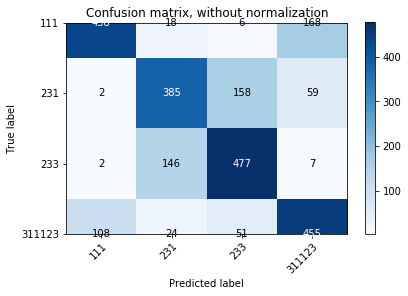

In [110]:
plot_confusion_matrix(verification_labels, predicted_labels, classes=classe,
                        title='Confusion matrix, without normalization')

In [112]:
print("Coeficiente Precisión")
print(sklearn.metrics.accuracy_score(verification_labels, predicted_labels))
print("coeficiente Kappa")
print (cohen_kappa_score (verification_labels, predicted_labels))

Coeficiente Precisión
0.7008785942492013
coeficiente Kappa
0.6010005748327092
